#  🤖 Hierarchical Corrective RAG and Search tutorial

This notebook will cover how to constructuct a Hierarchical Corrective RAG and Search team with a supervisor for routing, depending on the user query/intent.  To reduce reproduction of implemented code, links will be placed to the actual code and snippets will be embedded in markdown cells.  All agents and teams of agents can be found under: utils/agents.  Links will be provided to the files as the notebook progresses and explanations will be provided.  We will first start with the imports, including individual teams.  


### Imports

In [1]:
import os
import sys
from langchain_community.vectorstores import Chroma
from IPython.display import display, Markdown

current_dir = os.getcwd()
kit_dir = os.path.abspath(os.path.join(current_dir, ".."))
repo_dir = os.path.abspath(os.path.join(kit_dir, ".."))

sys.path.append(kit_dir)
sys.path.append(repo_dir)

from enterprise_knowledge_retriever.src.document_retrieval import DocumentRetrieval
from utils.agents.teams.corrective_rag_team import CRAGSupervisor
from utils.agents.teams.tavily_search_team import TavilySearchTeam
from utils.agents.teams.return_message_team import ReturnTeam
from utils.agents.corrective_rag import CorrectiveRAG
from utils.agents.teams.corrective_rag_team import TeamCRAG

CONFIG_PATH = os.path.join(kit_dir, "config.yaml")
examples = []

/Users/codym/CAP/aisk_forked/ai-starter-kit/agent_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the embedding model for semantic search

We will use our DocumentRetrieval class to load the embedding model and vectorstore.  We import this from the enterprise knowledge retrieval package for reuse.  Depending on your needs, you can choose between "sambastudio" or "cpu" for embeddings acceleration.  At present, only the E5 large v2 model is supported.

In [2]:
documentRetrieval = DocumentRetrieval()
*_, embedding_model_info, retrieval_info, _ = documentRetrieval.get_config_info()
embeddings = documentRetrieval.load_embedding_model()

2024-08-01 08:17:39,437 [INFO] - Load pretrained SentenceTransformer: intfloat/e5-large-v2


load INSTRUCTOR_Transformer


2024-08-01 08:17:40,061 [INFO] - Use pytorch device: cpu


max_seq_length  512


## Load the vectorstore for use as a base database

In [3]:
vectorstore = Chroma(
    persist_directory=kit_dir
    + "/data/uber_lyft.chromadb",  # Create for your own experiments.
    embedding_function=embeddings,
)

/Users/codym/CAP/aisk_forked/ai-starter-kit/agent_env/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 0.4. An updated version of the class exists in the langchain-chroma package and should be used instead. To use it run `pip install -U langchain-chroma` and import as `from langchain_chroma import Chroma`.
  warn_deprecated(
2024-08-01 08:17:40,395 [INFO] - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


## Load the teams

We are now ready to start bringing in teams that we have put together.  We will begin with the supervisor.  The supervisor is solely responsible for routing to other agents or teams of agents to perform a task.  By default, we will be routing uni-directionally, because we want a human in the loop on the front end at each step.  However, this does not need to be the case and can simply be modified by the control flow in the team that we will construct later.

### CRAG supervisor

The supervisor for this application can be found here: [CRAG Supervisor](./../../utils/agents/teams/corrective_rag_team.py)
The superisor requires state to determine the next step.  The state is a Typed Dictionary with the following entries:

    class SuperState(TypedDict):
        """
        A dictionary representing the current state of the supervisor.

        Args:
            question: The user question being asked.
            query_history: A list of previous queries made by the user.
            answer_history: A list of previous answers given by the team.
            teams: A list of team names.
            state: A dictionary containing the current state..
            next: The next action to take.
        """

        question : str
        query_history: Annotated[List[str], operator.add] = []
        answer_history: Annotated[List[str], operator.add] = []
        teams: List[str]
        state: dict
        next: str

Note that the query_history and answer_history keys are lists that will be appended to as the conversation progresses.  This is done by typing each with an Annotated List of strings with the add operator.

Given the prompt template: [Supervisor Prompt](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-supervisor_router.yaml), the supervisor routes to the next step given: the current question, the query_history, the answer_history, list of available teams, and the current state.  It will update: next.

The supervisor is a very simple agent and does not require as complex an initialization as the individual teams that will come later.  We will set the nodes and edges in just one method.  We inherit the state that we defined earlier and then add a single node for the supervisor router and one edge, which immediately sends the next step to END (back to the user).  A basic checkpointer (from the langgraph MemorySaver class) is used so we can modify state should we choose.  This will be done in the front end [app](./../streamlit/app.py) code so we can update the state of the query history and answer history as we go.  

Here is the code snippet:

    def create_supervisor(self) -> object:
        """
        Creates a compiled supervisor graph/app for the corrective RAG team.

        Returns:
            The compiled supervisor graph/app.
        """

        checkpointer = MemorySaver()

        sup_graph: StateGraph = StateGraph(SuperState)
        sup_graph.add_node('super_router', self.supervisor_router)
        sup_graph.add_edge('super_router', END)
        sup_graph.set_entry_point('super_router')
        sup_graph_compiled: CompiledGraph = sup_graph.compile(checkpointer=checkpointer)

        return sup_graph_compiled

We have a separate initialize methods as well, which initializes the LLM to be used and then a chain with it's appropriate prompt template.

    def initialize(self) -> None:
        """
        Initializes all the components of the supervisor app.

        Args:
            None

        Returns:
            None
        """
        
        self.init_llm()
        self.init_supervisor_router()

In [4]:
sup = CRAGSupervisor(
    configs=CONFIG_PATH,
    embeddings=embeddings,
    vectorstore=vectorstore,
    examples=examples,
)
sup.initialize()
supervisor_app = sup.create_supervisor()

#### Display the Supervisor Graph

2024-08-01 08:17:42,575 [INFO] - Browser listening on: ws://127.0.0.1:58500/devtools/browser/4a992ce9-5c74-4afb-b608-edbbc177eed8
2024-08-01 08:17:46,285 [INFO] - terminate chrome process...



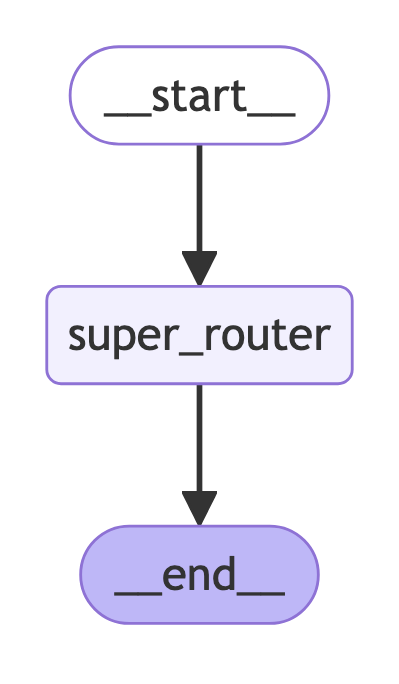

In [5]:
sup.display_graph(supervisor_app)

#### Supervisor Components

All of the functionalities that the supervisor has comes from the [SupervisorComponents](./../../utils/agents/supervisor.py) class, which inherits some helpful methods from the [BaseComponents](./../../utils/rag/base_components.py) class.  These components contain methods to initialize the supervisor router chain (with the appropriate prompt template) and the supervisor router method, which is the main method to be used.  This simply takes in the required variables and returns a JSON that contains "next" and the "output" of the chain.

#### Set config for the supervisor

We set the unique state for the supervisor so we can use the update_state method.  Time travel can also be done by using numerous states for the graph, but this will not be covered in this tutorial.  We will simply use a static config so we can update the general state of the supervisor when desired.

In [6]:
config = {"configurable": {"thread_id": "1234"}} #TODO: Find a better way 
# to generate uuids that don't update in the app.

### CRAG team

Now that the basic supervisor has been setup, we will now define the [Corrective RAG team](./../../utils/agents/corrective_rag.py).  The Corrective RAG team has its own state, which is not necessarily linked ot the supervisor state (they act indepedently, but may need to share information).  The state includes:

    class RAGGraphState(TypedDict):

        question : str
        generation : str
        documents : List[str]
        answers: List[str]
        original_question: str
        """
        Represents the state of a RAG (Retrieval Augmented Generation) graph.

        Args:
            question: The question being asked by the user.
            generation: The most recent generated text from the LLM agent.
            documents: A list of relevant documents retrieved from the vectorstore.
            answers: A list of possible answers that have been accumulated by the LLM agents.
            original_question: The original question asked - in case of subquery generation, etc..
        """

The Corrective RAG team does not require query history or answer history, as no chains used will take these inputs in any prompt templates.  We need the user question, the generation placeholder (to populate with the response), documents (to populate for sources, etc.), answers (there can be subqueries and multiple answers for each query), and the original question (you may need to answer an original question after answering subqueries).  Subquery generation is actually not covered here, but all components needed to add that functionality can be found in RAG components, which will be described following the graph display below.

The graph is more complex for Corrective RAG.  Due to this, we will use two seperate methods: 

    class CorrectiveRAG(RAGComponents, CodeGenComponents):
        def create_rag_nodes(self) -> StateGraph:
            """
            Creates the nodes for the CorrectiveRAG graph state.

            Args:
                None

            Returns:
                The StateGraph object containing the nodes for the CodeRAG graph state.
            """

            workflow: StateGraph = StateGraph(RAGGraphState)

            # Define the nodes

            workflow.add_node('initialize', self.initialize_rag)
            workflow.add_node('retrieve', self.retrieve)
            workflow.add_node('grade_documents', self.grade_documents)
            workflow.add_node('generate', self.rag_generate)
            workflow.add_node('failure_msg', self.failure_msg)
            workflow.add_node('return_final_answer', self.final_answer)

            return workflow

This method simply sets up all the nodes that will be used in the control flow of the graph.  

The next method puts the control flow together that routes between these nodes:

        def build_rag_graph(self, workflow: StateGraph) -> CompiledGraph:
            """
            Builds a graph for the RAG workflow.

            This method constructs a workflow graph that represents the sequence of tasks
            performed by the RAG system. The graph is used to execute the workflow and
            generate code.

            Args:
                workflow: The workflow object (StateGraph containing nodes) to be modified.

            Returns:
                The compiled application object for static CodeRAG
            """

            checkpointer = MemorySaver()

            workflow.set_entry_point('initialize')
            workflow.add_edge('initialize', 'retrieve')
            workflow.add_edge('retrieve', 'grade_documents')
            workflow.add_edge('grade_documents', 'generate')
            workflow.add_conditional_edges(
                'generate',
                self.check_hallucinations,
                {
                    'not supported': 'failure_msg',
                    'useful': 'return_final_answer',
                    'not useful': 'failure_msg',
                },
            )
            workflow.add_edge('failure_msg', 'return_final_answer')
            workflow.add_edge('return_final_answer', END)

            app: CompiledGraph = workflow.compile(checkpointer=checkpointer)

            return app

We again use a checkpointer just in case we would like to update the state at any given time.  It should be noted, though, that this is NOT required for this application, as we will be only updating the supervisor state, as the user submits queries, so we can track query and answer history.

The initialize method simply initializes all chains with their respective prompt templates as needed:

    def initialize(self) -> None:
        """
        Initializes all the components of the static CorrectiveRAG app.

        Args:
            None

        Returns:
            None
        """
        
        self.init_llm()
        self.init_retrieval_grader()
        self.init_qa_chain()
        self.init_retrieval_grader()
        self.init_hallucination_chain()
        self.init_grading_chain()
        self.init_failure_chain()
        self.init_final_generation()

In [7]:
rag = CorrectiveRAG(
    configs=CONFIG_PATH,
    embeddings=embeddings,
    vectorstore=vectorstore,
    examples=examples,
)

rag.initialize()
workflow = rag.create_rag_nodes()
rag_app = rag.build_rag_graph(workflow)

2024-08-01 08:17:47,085 [INFO] - Browser listening on: ws://127.0.0.1:58534/devtools/browser/0ba212c0-4811-4035-b9eb-8e21fcdd519f
2024-08-01 08:17:49,599 [INFO] - terminate chrome process...



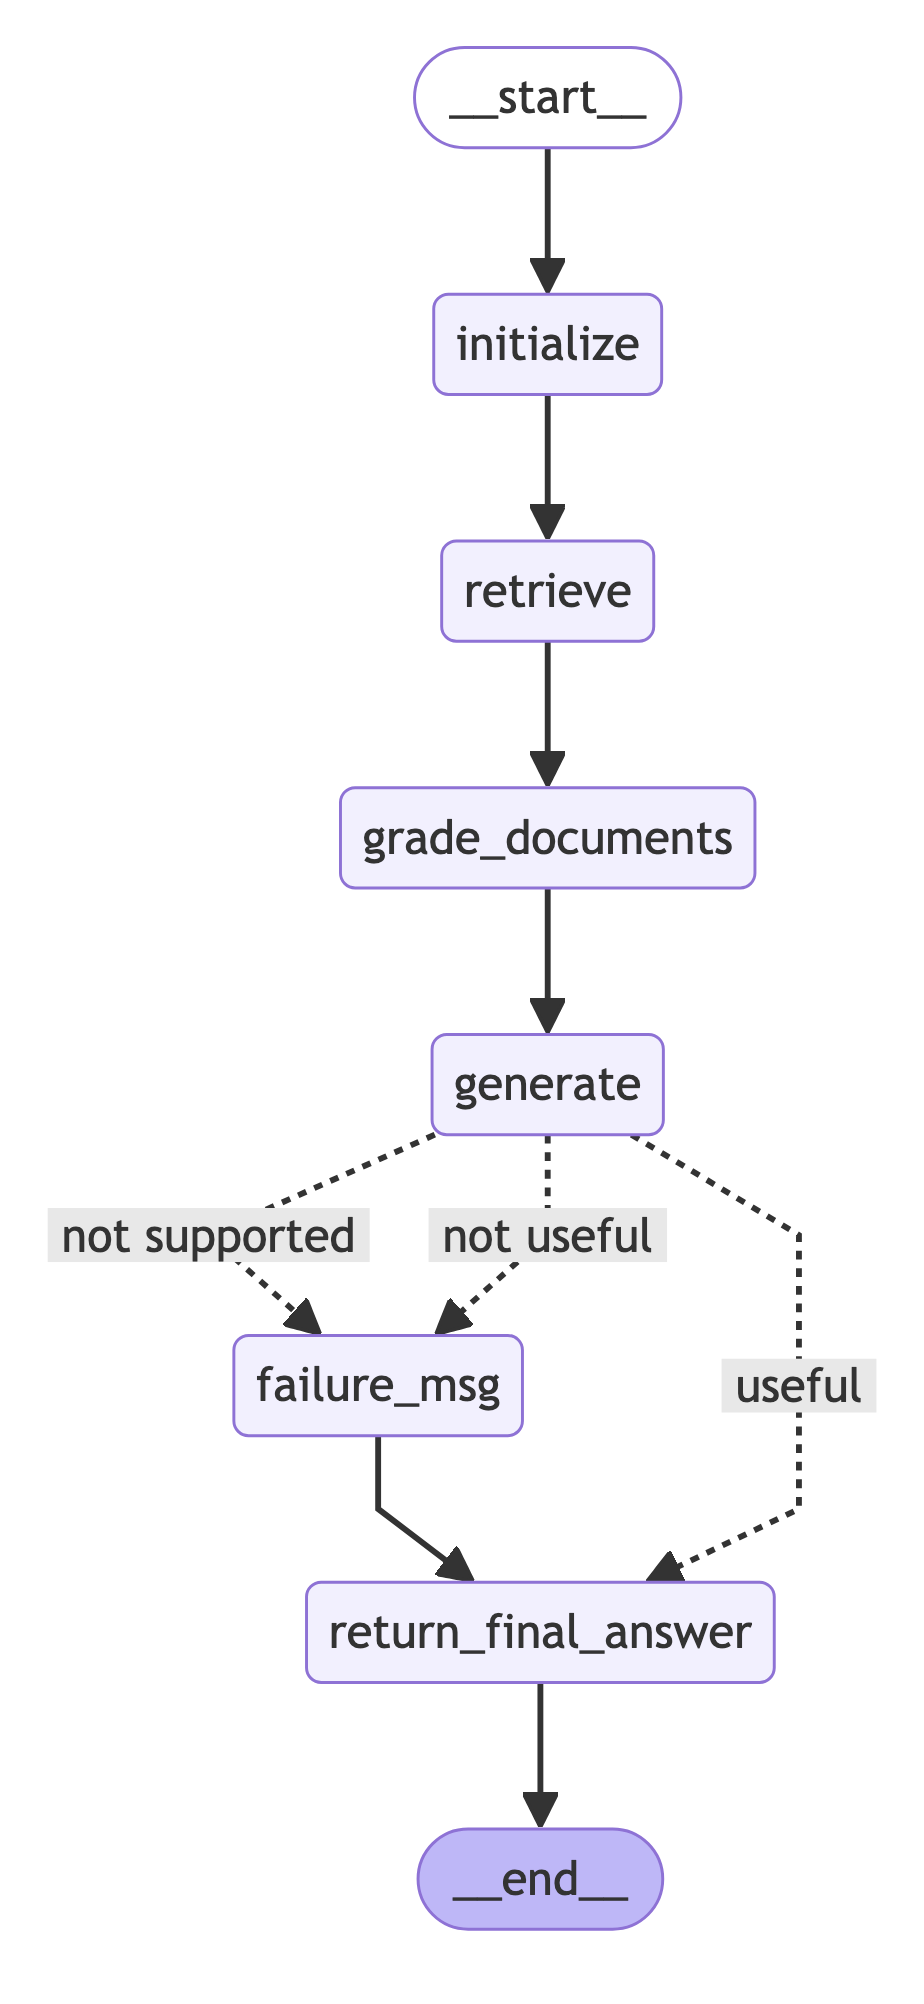

In [8]:
rag.display_graph(rag_app)

#### RAG Components

This graph is more complex than the supervisor graph.  It is still uni-dreictional, but one could also embed an internal supervisor if they wish.  

The [RAGComponents](./../../utils/rag/rag_components.py) class contains all the methods that are required for this team and more.  We will initialize the graph, which mainly sets the "original_question" to the question.  This is not needed for this example, but it IS required if subquery generation is added.  The functionalities to do this are contained within the class.

#### Flow:

 1. The user enters a query.
 2. The CRAG graph is initialized and sends the question to original_question (again not needed here, but applicable for graphs with subqueries).
 3. The question is sent to the retrieve method, which embeds the question and searches the vectorstore for similar contexts, that may be able to answer the question.  Only basic retrieval (with optional reranking) is used here, but the retrieve_w_filtering method also implements metadata filtering based on entities.  
 4. The retrieved documents are graded by a grading agent with the [retrieval grading](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-retrieval_grading.yaml) prompt template.  If the agent deems that the retrieved context of a document is relevant to the question, then it is appended to the documents list.  If it is not relevant, it is discarded.  This can be a helpful step, so noisey documents from coarse vectorstore retrieval are filtered before being sent to the QA chain.
 5. The QA/RAG generation is done with the appropriate agent.  The response is stored in a list of answers and generation.  The reason for this, again, is to allow for flexibility when implementing subeuery decomposition and answering.
 6. The generation is checked for hallucinations and failures.  If hallucinations are not detected, then the answer is gounded in documents.  This does not mean, hpwever, that the answer is useful, so each grounded answer is determined to be useful or not, with respect to the original question.  If the answer is not useful, routing tot he failure message is performed. Furthermore, if hallucinations are detected, the output is also routed to not supported.  
   - If the answer either contains hallucations or is not useful, the response is routed to the failure_msg method, which accepts the original question as input to the failure chain, which constructs a helpful answer for the user.
 7. The outputs are all finally passed to return final message.  The original question and the generation from the QA/RAG chain are sent to the final answer agent with the [final chain](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-final_chain.yaml) prompt template.  The agent simply massages an output for the user at this step.

### Tavily search team

Great!  We have our first team and our supervisor.  Now, we will put together the Tavily search team fro demonstration purposes.  You will need to sign up for the [Tavily service](https://tavily.com/) to use this functionality and enter the TAVILY_API_KEY in your .env file.

The [Tavily Search Team](./../../utils/agents/teams/tavily_search_team.py) is very similar in composition to the CRAG team.  It has a few differences, however.  It uses the Tavily API for search instead of vectorstore retrieval.  It similarly conducts document grading for retrieval relevancy and hallucination detection and usefulness determination:

The state is the same as the CRAG state (it could actually be reused, but we package up its own state for  modularity):

    class SearchGraphState(TypedDict):
        """
        Represents the state of a search graph.

        Args:
            question: The original question being asked by the user.
            generation: The current generation from a LLM agent in the pipeline.
            documents: A list of documents after retrieving from the vectorstore.
            answers: A list of answers that have been accumulated from the app.
            original_question: The original question being searched, which may need to bre retrieved/used after 
            query reformulation or subquery decomposition..
        """
        question: str
        generation: str
        documents: List[str]
        answers: List[str]
        original_question: str

We define a very similar set of nodes as well, inheriting a number of the same components:

        def create_search_nodes(self) -> StateGraph:
            """
            Creates the nodes for the TavilySearchTeam graph state.

            Returns:
                The StateGraph object containing the nodes for the TavilySearchTeam graph state.
            """

            workflow: StateGraph = StateGraph(SearchGraphState)

            # Define the nodes

            workflow.add_node('search', self.tavily_web_search)
            workflow.add_node('grade_documents', self.grade_documents)
            workflow.add_node('generate', self.rag_generate)
            workflow.add_node('failure_msg', self.failure_msg)
            workflow.add_node('return_final_answer', self.final_answer)

            return workflow

Note this structure is the same as CRAG, except that there is no initialization and there is a search node that is associated with the Tavily API as defined in [Tavily Searvch Components](./../../utils/search/tavily_search.py).

The workflow (including conditional edge routing) is also similar as CRAG:

        def build_search_graph(self, workflow: StateGraph) -> CompiledGraph:
            """
            Builds a graph for the RAG workflow.

            This method constructs a workflow graph that represents the sequence of tasks
            performed by the RAG system. The graph is used to execute the workflow and
            generate code.

            Args:
                workflow: The workflow object (StateGraph containing nodes) to be modified.

            Returns:
                The compiled application object for static TavilySearchTeam
            """

            checkpointer = MemorySaver()

            workflow.set_entry_point('search')
            workflow.add_edge('search', 'grade_documents')
            workflow.add_edge('grade_documents', 'generate')
            workflow.add_conditional_edges(
                'generate',
                self.check_hallucinations,
                {
                    'not supported': 'failure_msg',
                    'useful': 'return_final_answer',
                    'not useful': 'failure_msg',
                },
            )
            workflow.add_edge('failure_msg', 'return_final_answer')
            workflow.add_edge('return_final_answer', END)

            app: CompiledGraph = workflow.compile(checkpointer=checkpointer)

            return app

All required chains are initialized via its initialize method:

        def initialize(self) -> None:
            """
            Initializes all the components of the static TavilySearchTeam app.
            """
            
            self.init_llm()
            self.init_retrieval_grader()
            self.init_qa_chain()
            self.init_retrieval_grader()
            self.init_hallucination_chain()
            self.init_grading_chain()
            self.init_failure_chain()
            self.init_final_generation()

It may not be necessary to use document grading and hallucination detection and answer usefulness determination to cut down on latency, if desired.  All a developer needs to do now is to remove the grade documents node and edge, as well as the check hallucinations conditional edge.  If these edges are removed, the edges need to be redfined:

        def create_search_nodes(self) -> StateGraph:
            """
            Creates the nodes for the TavilySearchTeam graph state.

            Returns:
                The StateGraph object containing the nodes for the TavilySearchTeam graph state.
            """

            workflow: StateGraph = StateGraph(SearchGraphState)

            # Define the nodes

            workflow.add_node("search", self.tavily_web_search)
            workflow.add_node("generate", self.rag_generate)
            workflow.add_node("failure_msg", self.failure_msg)
            workflow.add_node("return_final_answer", self.final_answer)

            return workflow

In [9]:
search = TavilySearchTeam(
    configs=CONFIG_PATH,
    embeddings=embeddings,
    vectorstore=vectorstore,
    examples=examples,
)
search.initialize()
workflow = search.create_search_nodes()
search_app = search.build_search_graph(workflow)

2024-08-01 08:17:50,384 [INFO] - Browser listening on: ws://127.0.0.1:58544/devtools/browser/d2b61a50-69a4-442a-90e9-f34f4ce46914
2024-08-01 08:17:52,674 [INFO] - terminate chrome process...



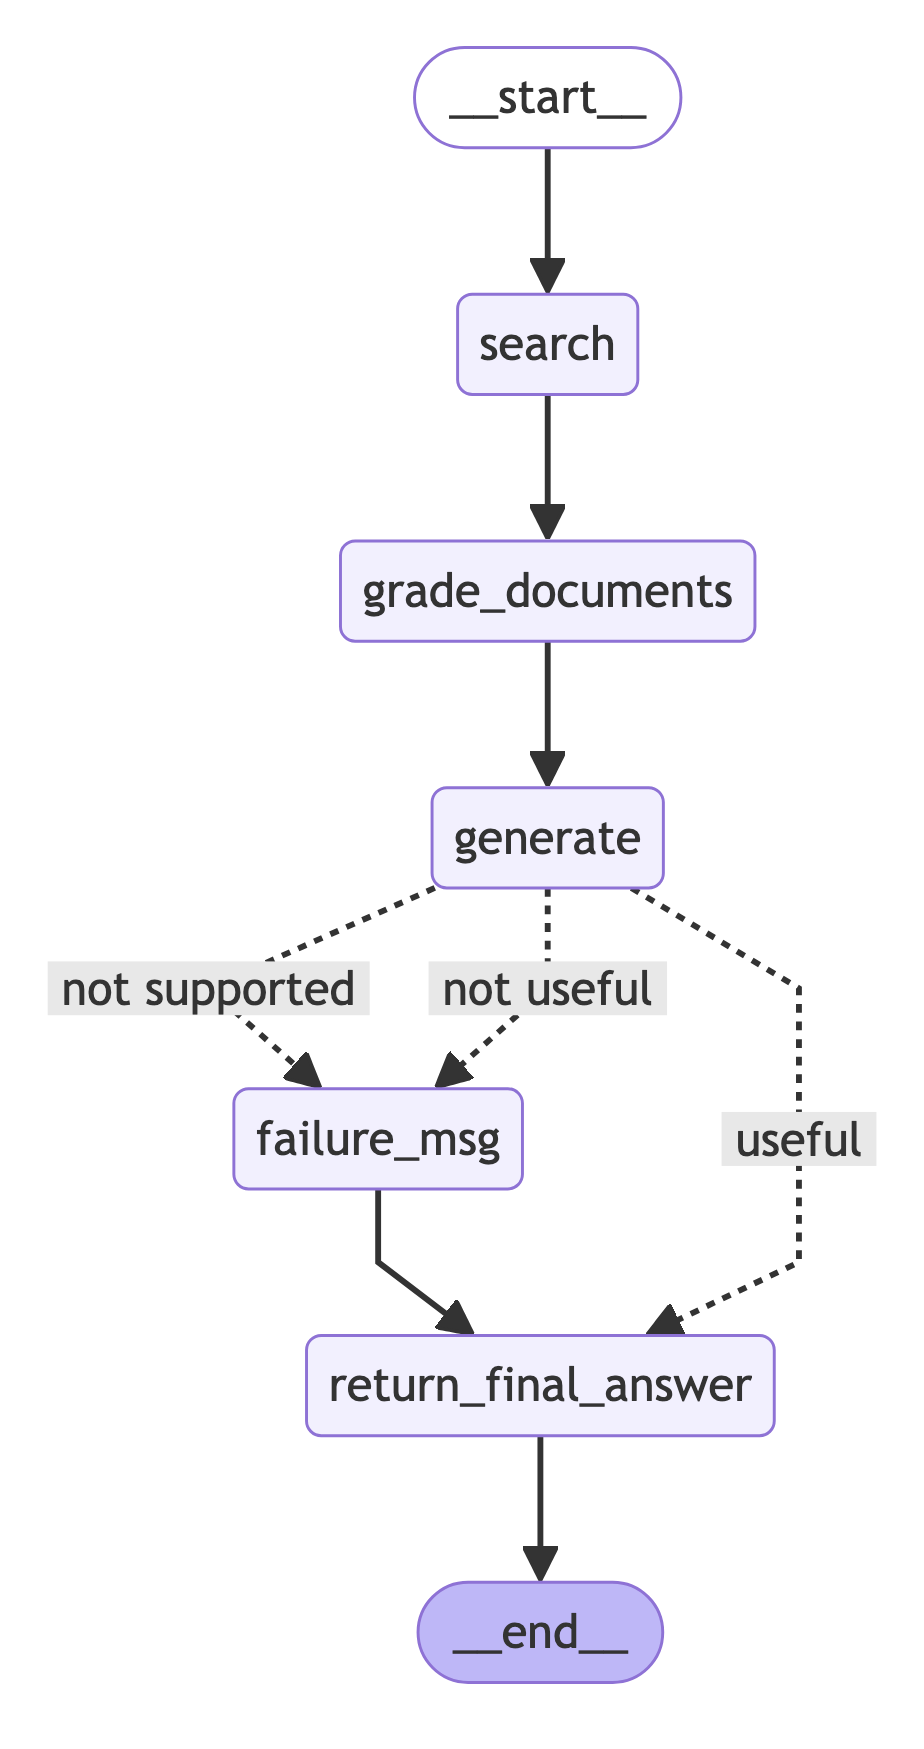

In [10]:
search.display_graph(search_app)

### Tavily Search Components

This graph unsurprisingly looks almost identical to our CRAG graph.  The [search components](./../../utils/search/tavily_search.py) contains the tavily_web_search method that calls the Langchain integration of the TavilySearchResults class.  

#### Flow:

The flow basically follows the CRAG flow, except there is no initialization and the retrieval step is replaced by Tavily search.

 1. The user enters a query.
 2. The question is sent to the tavily search API via the Langchain integration.  Both the retrieved contexts and urls are returned. 
 3. The retrieved contexts are graded by a grading agent with the [retrieval grading](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-retrieval_grading.yaml) prompt template.  If the agent deems that the retrieved context of a document is relevant to the question, then it is appended to the documents list.  If it is not relevant, it is discarded.  This can be a helpful step, so noisey documents from coarse vectorstore retrieval are filtered before being sent to the QA chain.
 4. The QA generation is done with the appropriate agent.  The response is stored in a list of answers and generation.  The reason for this, again, is to allow for flexibility when implementing subeuery decomposition and answering.
 5. The generation is checked for hallucinations and failures.  If hallucinations are not detected, then the answer is gounded in documents.  This does not mean, hpwever, that the answer is useful, so each grounded answer is determined to be useful or not, with respect to the original question.  If the answer is not useful, routing tot he failure message is performed. Furthermore, if hallucinations are detected, the output is also routed to not supported.  
   - If the answer either contains hallucations or is not useful, the response is routed to the failure_msg method, which accepts the original question as input to the failure chain, which constructs a helpful answer for the user.
 6. The outputs are all finally passed to return final message.  The original question and the generation from the QA/RAG chain are sent to the final answer agent with the [final chain](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-final_chain.yaml) prompt template.  The agent simply massages an output for the user at this step.

### Return Message Team

Now we add the final [team](./../../utils/agents/teams/return_message_team.py), which like the supervisor, is very simple.  We combine node and workflow definition like the supervisor, due to the simplicity of the task.  

We first define its independent state:

        class ReturnTeamState(TypedDict):
        """
        A typed dictionary representing the state of a team in a conversation.

        Args:
                question: The question being asked by the user.
                generation: The most recent generation from the team.
                next: The next action to take.
        """

        question: str
        generation: str
        next: str

It only requires the question, generation, and next.  It takes in next this time not to replace it's value, but to use the information to inform the user about what the last step was in its execution.

        class ReturnTeam(ReturnComponents):
                def create_return_team(self) -> CompiledGraph:
                        """
                        Creates the nodes for the ReturnTeam graph state.

                        Returns:
                        The StateGraph object containing the nodes for the ReturnTeam graph state.
                        """

                        checkpointer = MemorySaver()

                        return_graph: StateGraph = StateGraph(ReturnTeamState)
                        return_graph.add_node('return_message', self.return_message_to_user)
                        return_graph.add_edge('return_message', END)
                        return_graph.set_entry_point('return_message')
                        return_graph_compiled: CompiledGraph = return_graph.compile(checkpointer=checkpointer)

                        return return_graph_compiled

Here, we simply have the return_message_to_user function, which takes in the question, generation, and next, and returns a message to the user.  It uses the next to inform the user about what the last step was in its execution.  Finally, routing to END is done, so the user can determine the next step.

In [11]:
return_msg = ReturnTeam(
    configs=CONFIG_PATH,
    embeddings=embeddings,
    vectorstore=vectorstore,
    examples=examples,
)
return_msg.initialize()
return_app = return_msg.create_return_team()

2024-08-01 08:17:53,400 [INFO] - Browser listening on: ws://127.0.0.1:58553/devtools/browser/a4bc0055-dfc5-4a3f-a25a-e509b2c79a67
2024-08-01 08:17:55,627 [INFO] - terminate chrome process...



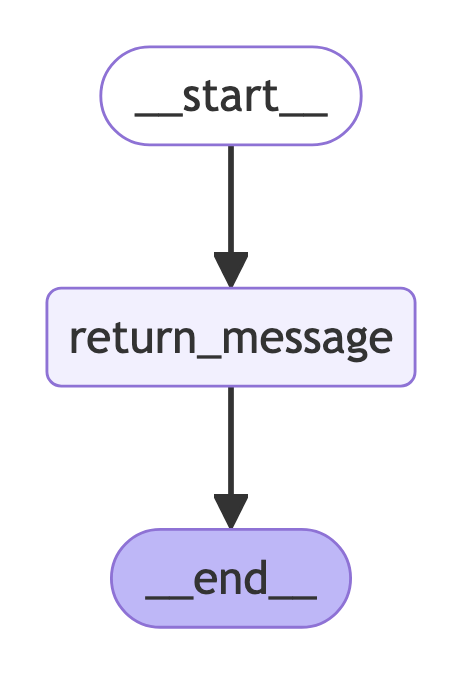

In [12]:
return_msg.display_graph(return_app)

### Return message components:

The [return message](./../../utils/agents/return_message.py) components for the return message contain an initialization method for the llm with the [return message prompt](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-return_message_prompt.yaml).  

To demonstrate how you can customize the overall feel of the assistant, I've also added: [Canadian return message prompt](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-return_message_prompt_CAD.yaml) and will use this for the notebook and this portion of the repo.

## Putting together the CRAG/Search Team with supervisor routing

We will first define the team's state as usual:

    class TeamRAGGraphState(TypedDict):
        """
        Represents the state of a team's RAG graph.

        Args:
            question: The user question being asked.
            generation: The most recent generation of the team.
            documents: A list of documents retrieved from the vectorstore.
            answers: A list of answers provided by the team.
            original_question: The original question being asked, in case of subquery generation, query reformulation, etc.
            next: The next step in the pipeline.
        """

        question: str
        generation: str
        documents: List[str]
        answers: List[str]
        original_question: str
        next: str

Note that we do not actually need the question_history or answer_history keys, because we will end up updating the supervisor's state directly, even though it will be embedded in the overall team.  

Here's where things get really fun.  We will initialize the team with agents or teams of agents:

        def __init__(
            self,
            supervisor_app: CompiledGraph,
            rag_app: CompiledGraph,
            search_app: CompiledGraph,
            return_app: CompiledGraph,
        ) -> None:
            """
            Initializes the Corrective RAG Team.

            Args:
                supervisor_app: The supervisor application.
                rag_app: The RAG application.
                search_app: The search application.
                return_app: The return message application.
            """

            self.team_app = StateGraph(TeamRAGGraphState)
            self.supervisor_app = supervisor_app
            self.rag_app = rag_app
            self.search_app = search_app
            self.return_app = return_app

These agents were instantiated previously, so we simply pass them to the supervisor.  In this case the supervisor has been set up to specifically take in the apps specified.  Though not generalized completely, this is still nice, since all we need to do is setup the appropriate nodes, which call the apps:

        def create_team_graph(self) -> None:
            """
            Creates the nodes for the TeamCRAG graph state.

            Returns:
                The StateGraph object containing the nodes for the TeamCRAG graph state.
            """

            self.team_app.add_node('supervisor', self.supervisor_app)
            self.team_app.add_node('rag', self.rag_app)
            self.team_app.add_node('search', self.search_app)
            self.team_app.add_node('return_message', self.return_app)

And then build the edges between the nodes as a workflow and compile as done previously for other teams:

        def build_team_graph(self) -> CompiledGraph:
            """
            Builds a graph for the TeamCRAG workflow.

            This method constructs a workflow graph that represents the sequence of tasks
            performed by the TeamCRAG system.

            Args:
                workflow: The workflow object (StateGraph containing nodes) to be modified.

            Returns:
                The compiled application object for TeamCRAG
            """

            checkpointer = MemorySaver()

            self.team_app.add_conditional_edges(
                'supervisor', lambda x: x['next'], {'rag': 'rag', 'search': 'search', 'END': END}
            )
            self.team_app.add_edge('rag', 'return_message')
            self.team_app.add_edge('search', 'return_message')
            self.team_app.add_edge('return_message', END)
            self.team_app.set_entry_point('supervisor')
            team_app: CompiledGraph = self.team_app.compile(checkpointer=checkpointer)

            return team_app

We also define a method for processing the information into simple response and sources:

        def call_rag(
            self, app: CompiledStateGraph, question: str, config: dict, kwargs: Dict[str, int] = {'recursion_limit': 50}
        ) -> tuple[dict[str, Any], dict[str, Any] | Any]:
            """
            Calls the RAG (Reasoning and Generation) app to generate an answer to a given question.

            Args:
                app: The RAG app object.
                question: The question to be answered.
                kwargs: Keyword arguments to be passed to the app.
                Defaults to {"recursion_limit": 50}
                Recursion limit controls how many runnables to invoke without
                reaching a terminal node.

            Returns:
                response: A dictionary containing the answer and source documents.
                    - "answer": The generated answer to the question.
                    - "source_documents": A list of source documents used
                    to generate the answer.
            """

            response = {}
            # type ignore is used because the invoke expects a runnable,
            # but using a runnable in this way will not work.
            output = app.invoke({'question': question}, config=config)  # type: ignore
            response['answer'] = output['generation']
            sources = output['documents']
            response['source_documents'] = sources

            return response, output

This will be helpful for lifting and shifting the app into other front ends, such as Streamlit, Gradio, Slack, etc.

The fact that we have assembled a team that works together using smaller teams, demonstrates that we have created a hierarchical team of agents.  This provides a nice modular framework for us to build on.  Furthermore, as components are built for various tasks, we can classify and orgranize them into our utilities and reuse them as we need when building new teams or extending the capabilities of existing ones.

In [13]:
team = TeamCRAG(
    supervisor_app=supervisor_app,
    rag_app=rag_app,
    search_app=search_app,
    return_app=return_app,
)

team.create_team_graph()
team_app = team.build_team_graph()

2024-08-01 08:17:56,481 [INFO] - Browser listening on: ws://127.0.0.1:58561/devtools/browser/af446b3d-445b-433d-8f65-5393a2422f91
2024-08-01 08:17:58,738 [INFO] - terminate chrome process...



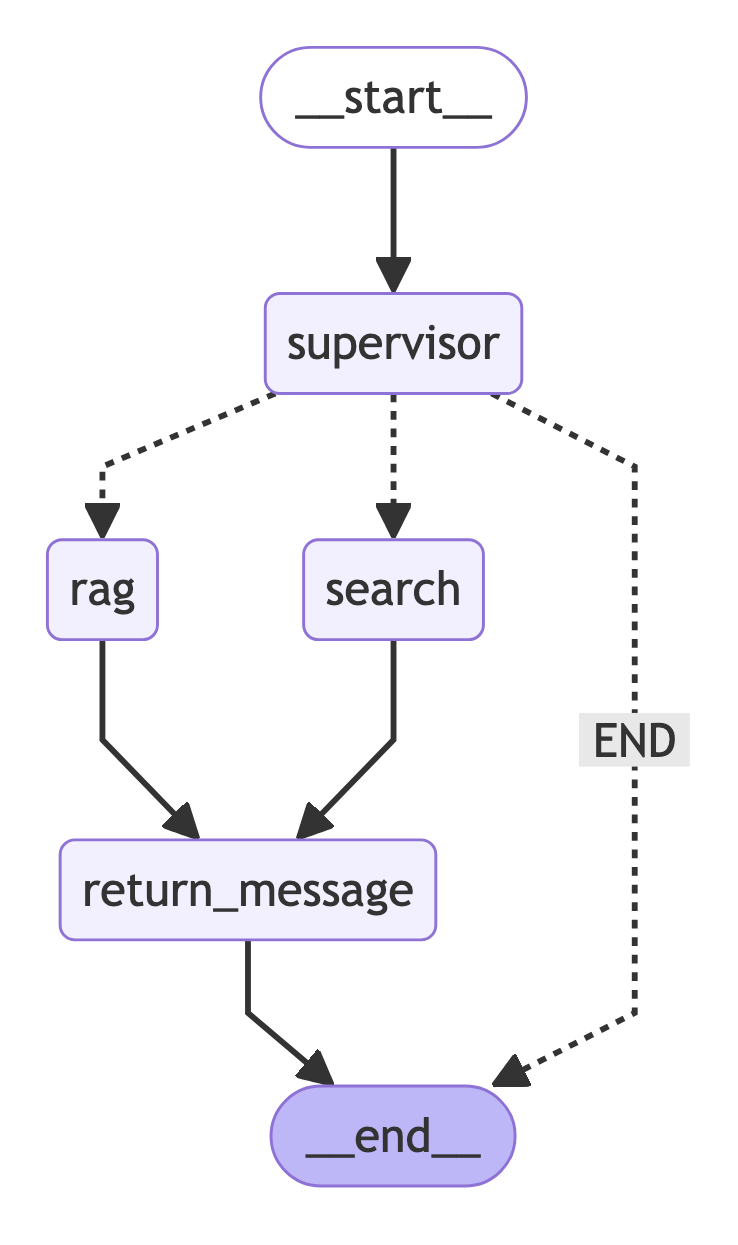

In [14]:
team.display_graph(team_app)

### Hierarchical Team Graph

We have now hidden much of the complexity in this pipeline within individual teams, which is nice for presentation purposes as a bonus.  This also allows us to understand and handle the individual states more simply, as we can visualize each team and/or agent independently.  Early on, I would recommend to iterate and check on what's required for each state until you are familiar and comfortable with the concept and patterns.

#### Flow

1. The user inputs a question.
2. The supervisor app checks the question, and given it's system prompt from the prmpt template, routes the question appropriately.
3.  Routing
    - If the question does not specify to search the internet or web and there is no answer history, the supervisor will route to rag.
    - If the question specifies that the supervisor should search the internet/web AND/OR if the answer history contains an apology message prompting the user to search the internet/web and the next user prompt is affirmative, the supervisor will route to search.  If a negative, it will route to END.
    - If the user asks a question that is already answered by the answer history, the supervisor will route to END.
4. If routing was done to either rag or search, the outputs will then be passed to the return message team, that formats and stylizes the outputs.
5. The return message team will then return the formatted message to the user by passing to END.

## Testing out the CRAG/Search team with human in the loop interactions

Let's work through a number of test cases and discuss what is happening.

### Question that cannot be answered by the current vectorstore

#### Question setup

We will ask about the CEO of SambaNova Systems, Rodrigo Liang.  We have instructed our supervisor to consult the vectorstore directly if no explicit mentions to the inernet or web are present in the question, OR, if there is no suggestion to do so in the answer history.  

In [15]:
response = team_app.invoke({"question": "Who is Rodrigo Liang?"}, config=config)
display(Markdown("---RESPONSE---"))
display(Markdown(response["generation"]))

---SUPERVISOR ROUTER INPUTS---
Who is Rodrigo Liang?
[]
[]
---NEXT ACTION---
rag
---Initializing---
---INITIAL STATE---
{'question': 'Who is Rodrigo Liang?', 'generation': None, 'documents': None, 'answers': None, 'original_question': None}
Who is Rodrigo Liang?
---RETRIEVING FOR QUESTION---
Who is Rodrigo Liang?
---RERANKING DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GENERATING---
---ANSWERING---
Who is Rodrigo Liang?
---DOCS---
number of approximate tokens (n words *1.3):  0.0

---ANSWER---
Could not find information.
---CHECK FOR HALLUCINATIONS---
{'score': 'no'}
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS---
---Fi

---RESPONSE---

Sorry about that, eh? I've searched high and low in my database, but I couldn't find any information on a fella named Rodrigo Liang. I've taken a good ol' rag through my knowledge base, but it seems I don't have any info on this individual. If you could give me a bit more context or details about who Rodrigo Liang is or what he's known for, I'd be happy to try and help you out. Or, if you'd like, I could try searching the internet for you to see if I can dig up some info. Would you like me to do that, buddy?

#### Result

As expected, the supervisor routed directly to the vectorstore.  Since the vectorstore does not contain this information, the return message team took the response of "Could not find information" and massaged it to provide a friendly and proactive response, asking the user if they would like the team to search the internet.

##### Update the state of the supervisor

We will now update the supervisor state outside of the application, so we can inject the user's response to the supervisor later.  We will add the previous query to query history and the response to answer history.

In [16]:
update_dict = {
    "query_history": ["Who is Rodrigo Liang?"],
    "answer_history": [response["generation"]],
}

supervisor_app.update_state(config, update_dict)

{'configurable': {'thread_id': '1234',
  'thread_ts': '1ef50089-26dc-6712-8002-f178833b83d0'}}

##### Let's now have a look at the state of the team to check that the update was successful

In [17]:
supervisor_app.get_state(config=config).values

{'question': 'Who is Rodrigo Liang?',
 'query_history': ['Who is Rodrigo Liang?'],
 'answer_history': ["Sorry about that, eh? I've searched high and low in my database, but I couldn't find any information on a fella named Rodrigo Liang. I've taken a good ol' rag through my knowledge base, but it seems I don't have any info on this individual. If you could give me a bit more context or details about who Rodrigo Liang is or what he's known for, I'd be happy to try and help you out. Or, if you'd like, I could try searching the internet for you to see if I can dig up some info. Would you like me to do that, buddy?"],
 'next': 'rag'}

#### Human in the loop interactions

Now we have updated state for the supervisor, which includes past message history between the user and the assistant.  

The last response in answer history prompts the user to search the internet.  It also has access to these histories and is instructed to route to search if the affirmative response is received.

In [18]:
response = team_app.invoke({"question": "Yes, please."}, config=config)
display(Markdown("---RESPONSE---"))
display(Markdown(response["generation"]))

---SUPERVISOR ROUTER INPUTS---
Yes, please.
['Who is Rodrigo Liang?']
["Sorry about that, eh? I've searched high and low in my database, but I couldn't find any information on a fella named Rodrigo Liang. I've taken a good ol' rag through my knowledge base, but it seems I don't have any info on this individual. If you could give me a bit more context or details about who Rodrigo Liang is or what he's known for, I'd be happy to try and help you out. Or, if you'd like, I could try searching the internet for you to see if I can dig up some info. Would you like me to do that, buddy?"]
---NEXT ACTION---
search
---WEB SEARCH---
Who is Rodrigo Liang?
[Document(metadata={'filename': ['https://www.rblt.com/tech-summit-biography/rodrigo-liang', 'https://spectrum.ieee.org/sambanova-ceo-ai-interview', 'https://podcasts.apple.com/us/podcast/rodrigo-liang-sambanova-ceo-shares-how-he-raised-more/id1476885647?i=1000620573801', 'https://www.zdnet.com/article/its-not-just-ai-this-is-a-change-in-the-enti

---RESPONSE---

Buddy! I've got the scoop on Rodrigo Liang for ya! After searchin' the web, I found out that Rodrigo Liang is the Co-Founder & CEO at SambaNova. That's right, eh? He's the big cheese, the head honcho, the top dog at that company! I took a gander at the internet to get the lowdown on this fella, and that's what I came up with. If you'd like me to dig deeper, I'd be happy to search the web some more for ya!

#### Result

The assistant now knows that the user wants to search the internet.  It suggests a search query for Rodrigo Liang.  The assistant also suggests that the user can ask questions about Rodrigo Liang's role at SambaNova Systems.  

This is helpful, since the user can now interact back and forth with the assistant team.  Although this is a relatively simple setup, one could envision asking if subqueries need to be corrected, could suggest to a user the a prompt is too vague, could ask if it would like to attempt to obtain examples and reformulate queries, use various tools, etc.

In [19]:
supervisor_app.get_state(config=config).values

{'question': 'Yes, please.',
 'query_history': ['Who is Rodrigo Liang?'],
 'answer_history': ["Sorry about that, eh? I've searched high and low in my database, but I couldn't find any information on a fella named Rodrigo Liang. I've taken a good ol' rag through my knowledge base, but it seems I don't have any info on this individual. If you could give me a bit more context or details about who Rodrigo Liang is or what he's known for, I'd be happy to try and help you out. Or, if you'd like, I could try searching the internet for you to see if I can dig up some info. Would you like me to do that, buddy?"],
 'next': 'search'}

In [20]:
supervisor_app.get_state(config=config).values

{'question': 'Yes, please.',
 'query_history': ['Who is Rodrigo Liang?'],
 'answer_history': ["Sorry about that, eh? I've searched high and low in my database, but I couldn't find any information on a fella named Rodrigo Liang. I've taken a good ol' rag through my knowledge base, but it seems I don't have any info on this individual. If you could give me a bit more context or details about who Rodrigo Liang is or what he's known for, I'd be happy to try and help you out. Or, if you'd like, I could try searching the internet for you to see if I can dig up some info. Would you like me to do that, buddy?"],
 'next': 'search'}

In [21]:
update_dict = {
    "query_history": ["Yes, please."],
    "answer_history": [response["generation"]],
}
supervisor_app.update_state(config, update_dict)

{'configurable': {'thread_id': '1234',
  'thread_ts': '1ef50089-8a3d-6b9e-8006-82fe243f1a43'}}

### Question that can be answered by the current vectorstore

Now let's ask a question that should have relevant documents in the vectorstore.  Note that we are not clearing the state, the supervisor should be able to understand that the latest answer and query should help routing.  Clearing state, or allowing uers to clear state in a front end, is a good idea, though, and can be simply implemented in the front end.

In [22]:
response = team_app.invoke({"question": "What was the revenue for Uber in 2021?"}, config=config)
display(Markdown("---RESPONSE---"))
display(Markdown(response["generation"]))

---SUPERVISOR ROUTER INPUTS---
What was the revenue for Uber in 2021?
['Who is Rodrigo Liang?', 'Yes, please.']
["Sorry about that, eh? I've searched high and low in my database, but I couldn't find any information on a fella named Rodrigo Liang. I've taken a good ol' rag through my knowledge base, but it seems I don't have any info on this individual. If you could give me a bit more context or details about who Rodrigo Liang is or what he's known for, I'd be happy to try and help you out. Or, if you'd like, I could try searching the internet for you to see if I can dig up some info. Would you like me to do that, buddy?", "Buddy! I've got the scoop on Rodrigo Liang for ya! After searchin' the web, I found out that Rodrigo Liang is the Co-Founder & CEO at SambaNova. That's right, eh? He's the big cheese, the head honcho, the top dog at that company! I took a gander at the internet to get the lowdown on this fella, and that's what I came up with. If you'd like me to dig deeper, I'd be ha

---RESPONSE---

Buddy! I've got the answer for ya! According to my database, the revenue for Uber in 2021 was a whoppin' $17,455 million! I just retrieved that info from my trusty database, so you can bet it's accurate. Would you like me to search the internet for any additional info on Uber's financials, eh?

#### Result

The supervisor was able to understand the user's intent and route to the correct team to obtain a valid answer.  This is despite the fact that the state still contains historical questions and answers.  The prompt template has helped with this.

We can double check the state to verify that this is true.

In [23]:
update_dict = {
    "query_history": ["What was the revenue for Uber in 2021?"],
    "answer_history": [response["generation"]],
}

supervisor_app.update_state(config, update_dict)

{'configurable': {'thread_id': '1234',
  'thread_ts': '1ef5008a-c7c4-6598-800a-4e5000b1b08c'}}

In [24]:
team_app.get_state(config=config).values

{'question': 'What was the revenue for Uber in 2021?',
 'generation': "Buddy! I've got the answer for ya! According to my database, the revenue for Uber in 2021 was a whoppin' $17,455 million! I just retrieved that info from my trusty database, so you can bet it's accurate. Would you like me to search the internet for any additional info on Uber's financials, eh?",
 'documents': [Document(metadata={'data_source': '{"url": "/Users/codym/CAP/aisk_forked/ai-starter-kit/enterprise_knowledge_retriever/data/tmp/uber.pdf", "date_created": "2024-07-10 11:08:21.633523", "date_modified": "2024-07-10 11:08:21.633523", "date_processed": "2024-07-10T16:08:26.695200", "permissions_data": [{"mode": 33188}]}', 'element_id': '92159d728b1b5fd3009c16b963bb4c7b', 'file_directory': '/Users/codym/CAP/aisk_forked/ai-starter-kit/enterprise_knowledge_retriever/data/tmp', 'filename': 'uber.pdf', 'filetype': 'application/pdf', 'languages': 'eng', 'last_modified': '2024-07-10T11:08:21', 'orig_elements': 'eJy1VUtv

### Question that can be answered by the answer history

Let's ask a question that is basically already answered to see what happens and where the supervisor routes to.

In [25]:
response = team_app.invoke({"question": "What was the revenue for Uber in 2021?"}, config=config)
display(Markdown("---RESPONSE---"))
display(Markdown(response["generation"]))

---SUPERVISOR ROUTER INPUTS---
What was the revenue for Uber in 2021?
['Who is Rodrigo Liang?', 'Yes, please.', 'What was the revenue for Uber in 2021?']
["Sorry about that, eh? I've searched high and low in my database, but I couldn't find any information on a fella named Rodrigo Liang. I've taken a good ol' rag through my knowledge base, but it seems I don't have any info on this individual. If you could give me a bit more context or details about who Rodrigo Liang is or what he's known for, I'd be happy to try and help you out. Or, if you'd like, I could try searching the internet for you to see if I can dig up some info. Would you like me to do that, buddy?", "Buddy! I've got the scoop on Rodrigo Liang for ya! After searchin' the web, I found out that Rodrigo Liang is the Co-Founder & CEO at SambaNova. That's right, eh? He's the big cheese, the head honcho, the top dog at that company! I took a gander at the internet to get the lowdown on this fella, and that's what I came up with.

---RESPONSE---

Buddy! I've got the answer for ya! According to my database, the revenue for Uber in 2021 was a whoppin' $17,455 million! I just retrieved that info from my trusty database, so you can bet it's accurate. Would you like me to search the internet for any additional info on Uber's financials, eh?

In [26]:
supervisor_app.get_state(config=config).values

{'question': 'What was the revenue for Uber in 2021?',
 'query_history': ['Who is Rodrigo Liang?',
  'Yes, please.',
  'What was the revenue for Uber in 2021?'],
 'answer_history': ["Sorry about that, eh? I've searched high and low in my database, but I couldn't find any information on a fella named Rodrigo Liang. I've taken a good ol' rag through my knowledge base, but it seems I don't have any info on this individual. If you could give me a bit more context or details about who Rodrigo Liang is or what he's known for, I'd be happy to try and help you out. Or, if you'd like, I could try searching the internet for you to see if I can dig up some info. Would you like me to do that, buddy?",
  "Buddy! I've got the scoop on Rodrigo Liang for ya! After searchin' the web, I found out that Rodrigo Liang is the Co-Founder & CEO at SambaNova. That's right, eh? He's the big cheese, the head honcho, the top dog at that company! I took a gander at the internet to get the lowdown on this fella, an

#### Result

As we can see, the supervisor was able to understand the user's intent and route to the correct team to obtain a valid answer.  It has determined that the query and answer already exists in the state and simply routes to END.

## Conclusion

Hopefully this tutorial has been helpful in understanding how to build hierarchical teams of agents and agentic teams.  A supervisor, which is a LLM, can route to different teams based on the user's intent.  Each team and/or team member can have its own LLM (and sets of deterministic tools), which can be trained to answer questions based on its specific domain.  The supervisor can also maintain a state to remember past questions and answers, which can be useful for maintaining context.  This is a very flexible and powerful approach to building conversational AI systems.

Remember, the key to successful hierarchical teams is to ensure that the teams are appropriately trained and can answer questions based on their domain.  SambaNova Systems provides extremely fast inference AND fine tuning capabilities for Enterprise workloads in production.

The structure of the repo is intended to be laid out in a fashion that allows for reusability, so have fun mixing and matching (or adding) components and/or agents with different tool using capabilities.